# Real Estate Price Prediction Project

## Introduction
Creating a Machine Learning model to predict the home prices in Bangalore, India. We are going to use the dataset from Kaggle.com.
We are also going to create a single page website which will provide the front end to access our model for predictions.

The following data science concepts are used in this project:
* Data loading and cleaning
* Outlier detection and removal
* Feature engineering
* Dimensionality reduction
* GridSearchCV for hyperparameter tunning
* K-Fold cross validation 

Technology and tools used in this project:
* Python
* Numpy and Pandas for data cleaning
* Matplotlib for data visualization
* Sklearn for model building
* Jupyter Notebook via Visual Studio Code
* Python flask for http server
* HTML/CSS/Javascript for UI

## Steps
1. We will first build a model using sklearn and linear regression using banglore home prices dataset from kaggle.com.
2. Second step would be to write a python flask server that uses the saved model to serve http requests.
3. Third component is the website built in html, css and javascript that allows user to enter home square ft area, bedrooms etc and it will call python flask server to retrieve the predicted price. 

  ```
  Step#1: Import the required libraries
  Step#2: Load the data
  Step#3: Understand the data
          - Drop unnecessary columns
  Step#4: Data Cleaning
          - Check for NaN values
          - Verify unique values of each column
          - Make sure values are correct (e.g. 15 BHK home with 2000 Sqrft size is wrong)
  Step#5: Feature Engineering
          - Dimesionality Reduction
          - Outlier removal using domain knowledge (2bhk price < 3bhk price, size per bhk >= 300 sqft)
          - Outlier removal using standard deviation and mean 
  Step#6: Build Machine Learning Model
          - One Hot Encoding
          - Separating dependent and independent features
          - Spliting the data for training and testing
          - Using K-Fold cross validation to measure accuracy
          - Using the GridSearchCV method to find the best algorithm for our model
  Step#7: Testing the model
  Step#8: Exporting
  ```

## Dataset Reference
* [Bengaluru House price data](https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data/data)
* I have also uploaded the csv file in this repository [Bengaluru_House_Data.csv](model/Bengaluru_House_Data.csv) 

Reference
[codebasics](https://www.youtube.com/playlist?list=PLeo1K3hjS3uu7clOTtwsp94PcHbzqpAdg)


## Step#1: Import Libraries


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib 

import warnings
warnings.filterwarnings('ignore')

## Step#2: Load the data

In [8]:
df1 = pd.read_csv('Bengaluru_House_Data.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


## Step#3: Understand the data
* Finalize the columns to work with and drop the rest of them

In [9]:
df1.shape

(13320, 9)

In [10]:
# exploring 'area_type' column
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

### Dropping features

For the purpose of simplifying the model, we assume that *area_type, society, balcony, availability* columns are unnecessary and we can safely remove them.

In [11]:
df2 = df1.drop(columns=['area_type','society', 'balcony', 'availability'])
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


## Step#4: Data Cleaning

### Handling Null/missing values and duplicates

In [12]:
# checking for NaNs
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [13]:
df2.shape

(13320, 5)

In [14]:
# dropping NaNs
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [15]:
# dropping duplicates
df4 = df3.drop_duplicates()
print(f'We have dropped {df3.shape[0]-df4.shape[0]} duplicates.')

We have dropped 881 duplicates.


### Transforming columns to appropriate datatypes

##### Unifying 'size' values

In [16]:
# exploring 'size' column
df4['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

Based on domain knowledge we know that e.g. 3-Bedroom and 3 BHK are the same thing.

So we create a new column 'bhk' with integer values only.

In [17]:
df4.loc[:, 'bhk'] = df4['size'].apply(lambda x: int(x.split(' ')[0]))
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [18]:
df4['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

#### Unifying 'total_sqft' values

In [19]:
# exploring 'total_sqft' column
df4['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

As we can see, some of the values are written as a range e.g. '1133 - 1384'. We unify all values as float.

In [20]:
# defining a function to find float values only
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [21]:
# we use the ~ operator to show non float values
df4[~df4['total_sqft'].apply(is_float)]

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...,...
12955,Thanisandra,3 BHK,1437 - 1629,3.0,75.885,3
12975,Whitefield,2 BHK,850 - 1060,2.0,38.190,2
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Harlur,2 BHK,1200 - 1470,2.0,72.760,2


In [22]:
# defining a function to handle range values (e.g '2100 - 2850') 
# and ignoring the rest (e.g. '142.84Sq. Meter')
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        # split the token into 2 parts and calculate the average
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None  

In [23]:
df5 = df4.copy()
df5['total_sqft'] = df5['total_sqft'].apply(convert_sqft_to_num)
df5.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [24]:
# validation of the new data, e.g. for the value '3067 - 8156'
idx = df4[df4.total_sqft == '3067 - 8156'].index[0]
df5.loc[idx].to_frame().T

,location,size,total_sqft,bath,price,bhk
122,Hebbal,4 BHK,5611.5,4.0,477.0,4


In [25]:
# checking for NaNs because of ignored values (e.g. '142.84Sq. Meter')
df5.isna().sum()

location       0
size           0
total_sqft    46
bath           0
price          0
bhk            0
dtype: int64

In [26]:
# dropping NaN values
df5.dropna(inplace=True)
df5.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
bhk           0
dtype: int64

#### Currency conversion

In [27]:
# renaming 'price' column to 'price_INR'
df6 = df5.rename(columns={'price': 'price_INR'})

In [28]:
# converting to USD
# 1 INR = 0.0... USD
INR_RATE = 0.012075241 
df6['price_USD'] = df6.price_INR.apply(lambda x: round(x*100000*INR_RATE))

In [29]:
# dropping old 'price_INR' column
df6.drop(columns='price_INR', inplace=True)
df6.head()

,location,size,total_sqft,bath,bhk,price_USD
0,Electronic City Phase II,2 BHK,1056.0,2.0,2,47178
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,4,144903
2,Uttarahalli,3 BHK,1440.0,2.0,3,74866
3,Lingadheeranahalli,3 BHK,1521.0,3.0,3,114715
4,Kothanur,2 BHK,1200.0,2.0,2,61584


## Step#5: Feature Engineering

#### Adding 'price_per_sqft' feature

In this step, we are adding a new feature that will be helpful in detecting and removing outliers later. 

In [30]:
df6['price_USD_per_sqft'] = df6['price_USD']/df6['total_sqft']
df6.head()

,location,size,total_sqft,bath,bhk,price_USD,price_USD_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,2,47178,44.676136
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,4,144903,55.731923
2,Uttarahalli,3 BHK,1440.0,2.0,3,74866,51.990278
3,Lingadheeranahalli,3 BHK,1521.0,3.0,3,114715,75.420776
4,Kothanur,2 BHK,1200.0,2.0,2,61584,51.320000


#### 'location' dimensionality reduction

In [31]:
# exploring 'location' column
len(df6['location'].unique())

1298

The 1298 value creates a high dimensionality problem. If we apply One Hot Encoding, we will get a large number of features.

In [32]:
# checking the number of rows for each location
df6.location = df6.location.apply(lambda x: x.strip())
location_stats = df6['location'].value_counts()
location_stats

location
Whitefield                               500
Sarjapur  Road                           357
Electronic City                          275
Thanisandra                              224
Kanakpura Road                           215
                                        ... 
1Channasandra                              1
Bidere Agarahara, Behind Safal market      1
Grihalakshmi Layout                        1
Vijayabank bank layout                     1
Abshot Layout                              1
Name: count, Length: 1287, dtype: int64

In [33]:
# checking how many locations have <=10 data points
len(location_stats[location_stats<=10])

1057

In order to simplify the future creation of the model, we decide to rename the locations with <=10 data points to 'other'. 

This approach will significantly reduce the number of features after One Hot Encoding.

In [34]:
# applying rename lambda function
df6['location'] = df6['location'].apply(lambda x: 'other' if x in location_stats[location_stats<=10] else x)
df6

,location,size,total_sqft,bath,bhk,price_USD,price_USD_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,2,47178,44.676136
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,4,144903,55.731923
2,Uttarahalli,3 BHK,1440.0,2.0,3,74866,51.990278
3,Lingadheeranahalli,3 BHK,1521.0,3.0,3,114715,75.420776
4,Kothanur,2 BHK,1200.0,2.0,2,61584,51.320000
...,...,...,...,...,...,...,...
13314,Green Glen Layout,3 BHK,1715.0,3.0,3,135243,78.858892
13315,Whitefield,5 Bedroom,3453.0,4.0,5,278938,80.781350
13316,other,4 BHK,3600.0,5.0,4,483010,134.169444
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,2,72451,63.497809


In [35]:
print(f"Unique locations before: {len(df5['location'].unique())}. And after: {len(df6['location'].unique())}.")

Unique locations before: 1298. And after: 231.


### Outlier Detection and Removal

Outliers are data points that are data errors, but sometimes represent extreme variation. We can use techniques such as:

* Standard deviation
* Domain knowledge

#### 'total_sqft' outliers

Based on domain knowledge and conversation with  business manager we know that the typical bedroom is at least 300 sqft.

In [36]:
df6[df6.total_sqft/df6.bhk < 300]

,location,size,total_sqft,bath,bhk,price_USD,price_USD_per_sqft
9,other,6 Bedroom,1020.0,6.0,6,446784,438.023529
45,HSR Layout,8 Bedroom,600.0,9.0,8,241505,402.508333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,6,181129,128.734186
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,8,102640,76.029630
70,other,3 Bedroom,500.0,3.0,3,120752,241.504000
...,...,...,...,...,...,...,...
13221,other,9 Bedroom,1178.0,9.0,9,90564,76.879457
13277,other,7 Bedroom,1400.0,7.0,7,263240,188.028571
13279,other,6 Bedroom,1200.0,5.0,6,156978,130.815000
13281,Margondanahalli,5 Bedroom,1375.0,5.0,5,150941,109.775273


In [37]:
# removing outliers
df7 = df6[~(df6.total_sqft/df6.bhk < 300)]

#### 'price_USD_per_sqft' outliers - std & mean

In [38]:
# exploring 'price_USD_per_sqft' column
df7.price_USD_per_sqft.describe()

count    11590.000000
mean        77.309134
std         51.600203
min          3.234102
25%         51.383830
50%         64.567958
75%         84.526533
max       2130.924706
Name: price_USD_per_sqft, dtype: float64

As we can see, the variance in prices is really quite large (*max $2130.92* vs *min $3.23*). How to deal with it?

First of all, we assume that the data in 'price_USD_per_sqft' has a normal distribution. 

We know from theory that about 95% of the data are within 2 standard deviations of the mean. 

So in our case: (mean - 2*std) < data_values < (mean + 2 *std) are outliers.

In [39]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame() 
    # Group the DataFrame by 'location'
    # This will allow us to remove the outliers for each individual location
    for key, subdf in df.groupby('location'):  
        mean_price = subdf['price_USD_per_sqft'].mean()
        std_price = subdf['price_USD_per_sqft'].std()
        # Filter the data within 2 standard deviation from the mean price
        filtered_subdf = subdf[(subdf['price_USD_per_sqft'] > (mean_price - 2*std_price)) & 
                               (subdf['price_USD_per_sqft'] < (mean_price + 2*std_price))]
        # Concatenate the filtered data for this location with the overall filtered DataFrame
        df_out = pd.concat([df_out, filtered_subdf], ignore_index=True)
    return df_out


In [40]:
# removing outliers
df8 = remove_pps_outliers(df7)

In [41]:
print(f'{df7.shape[0] - df8.shape[0]} outliers were removed.')

481 outliers were removed.


#### 'price' & 'total_sqft' outliers - domain knowledge

The larger the apartment, the higher the price should be. Let's compare the prices of a 2 bedroom vs 3 bedroom in the same location.

In [42]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    plt.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(bhk2.total_sqft, bhk2.price_USD, color='blue', label='2 BHK')
    plt.scatter(bhk3.total_sqft, bhk3.price_USD, color='green', marker='x', label='3 BHK')
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price (USD)')
    plt.title(location)
    plt.legend()

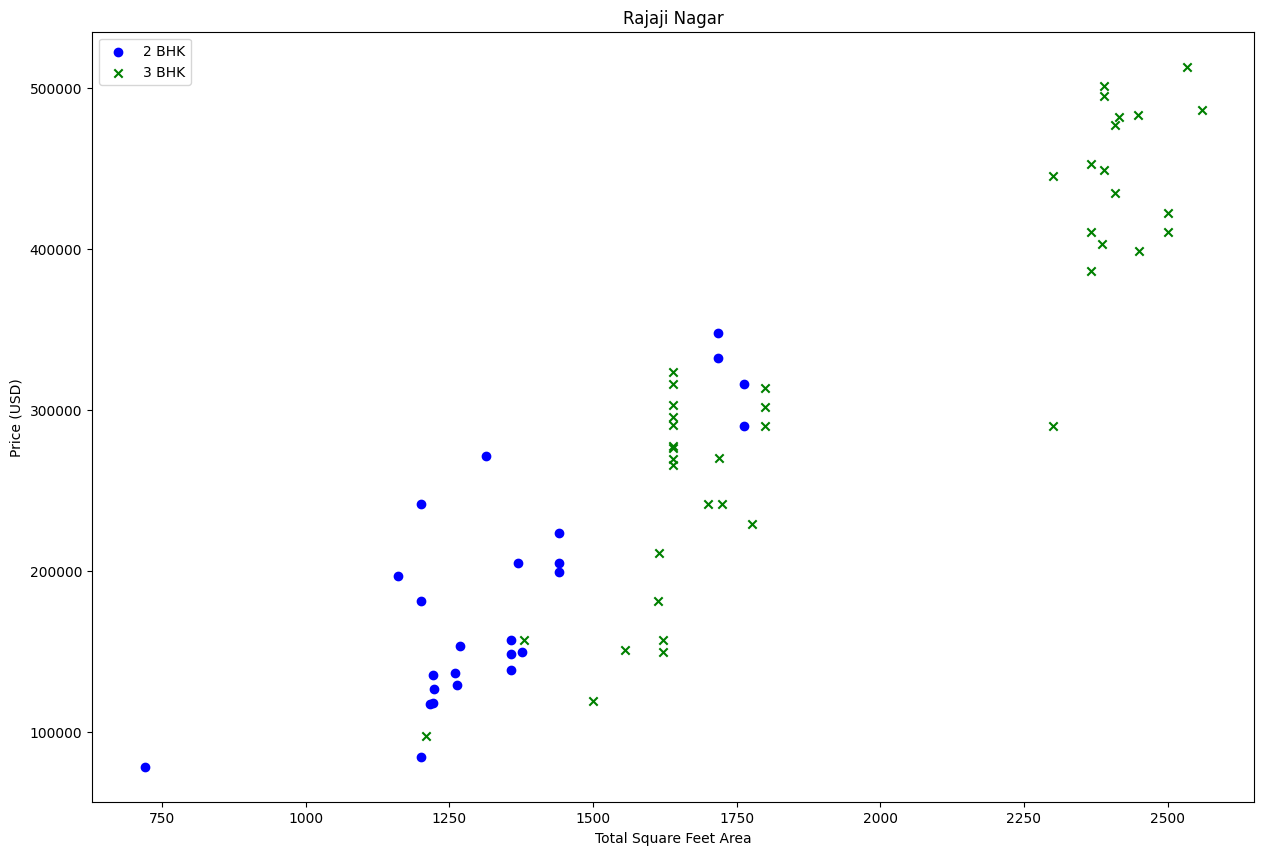

In [43]:
plot_scatter_chart(df8, 'Rajaji Nagar')

We can see that for the same location there are 3-bedroom apartments at the price of a 2-bedroom apartment (with the same feet area).

We treat such apartments as outliers.

What we will do is, for a given location, we will build a dictionary of statistics for each type of BHK:
```
{
    '1' : {
        'mean': 58.42,
        'std: 21.68,
        'count': 22
    },
    '2' : {
        'mean': 50.96,
        'std: 14.97,
        'count': 164
    },    
}
```
etc.

Now we remove those bedroom apartments whose 'price_USD_per_sqft' is lower than the mean for apartments with 1 bedroom less.

In [44]:
def remove_bhk_outliers(df):
    exclude_indices = []

    # Iterate over each location
    for location, location_df in df.groupby('location'):
        # Calculate statistics for each bhk within the location
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': bhk_df['price_USD_per_sqft'].mean(),
                'std': bhk_df['price_USD_per_sqft'].std(),
                'count': bhk_df.shape[0]
            }
        
        # Iterate over each bhk within the location
        for bhk, bhk_df in location_df.groupby('bhk'):
            # Get statistics for previous bhk if it exists
            prev_stats = bhk_stats.get(bhk - 1)
            if prev_stats and prev_stats['count'] > 5:
                # Identify outliers and extend their indices to exclude_indices
                exclude_indices.extend(bhk_df.index[bhk_df['price_USD_per_sqft'] < prev_stats['mean']])
    # Drop rows with indices present in exclude_indices
    return df.drop(exclude_indices, axis='index')

In [45]:
# removing outliers
df9 = remove_bhk_outliers(df8)
print(f'{df8.shape[0] - df9.shape[0]} outliers were removed.')

3315 outliers were removed.


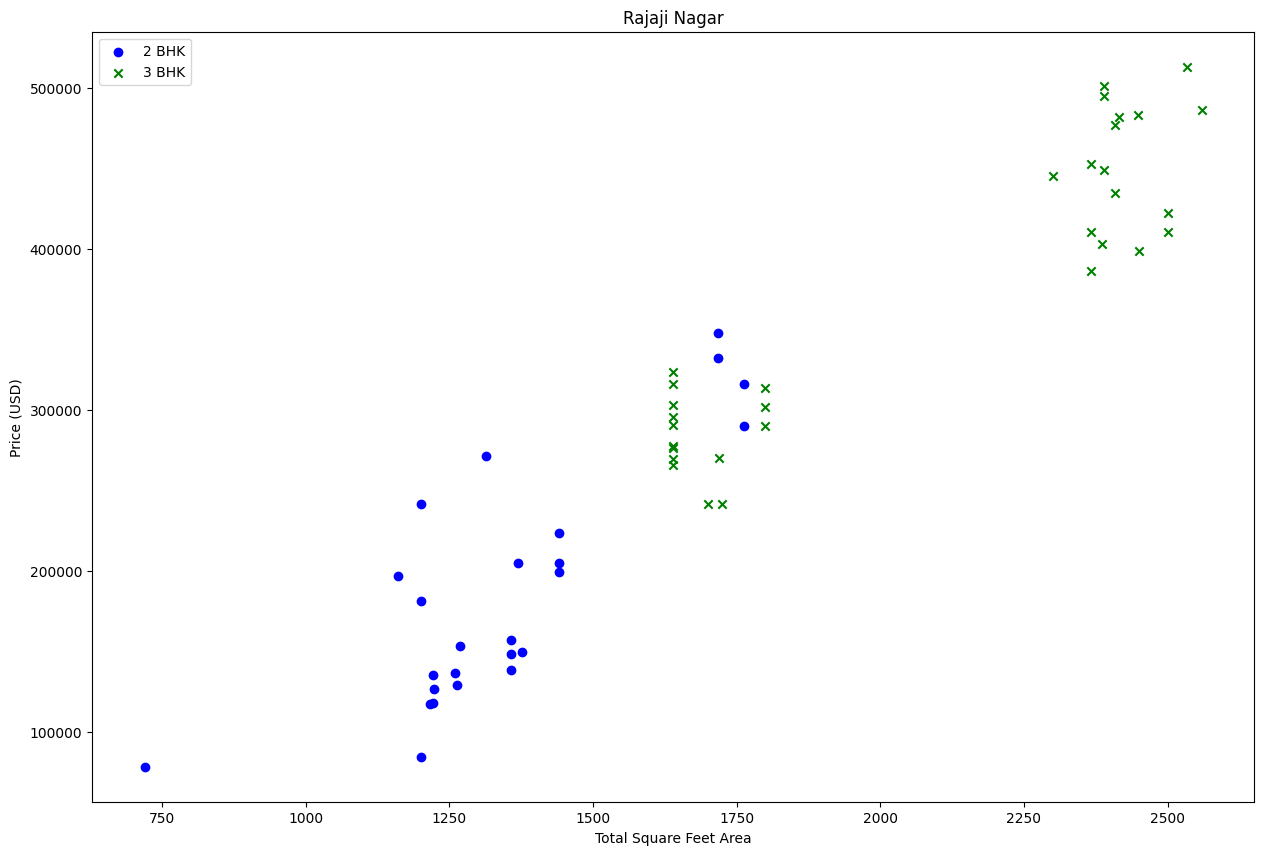

In [46]:
# let re-check the price using our defined scatter plot function
plot_scatter_chart(df9, 'Rajaji Nagar')

**Using a histogram to find the distribution of 'price_per_sqft'**

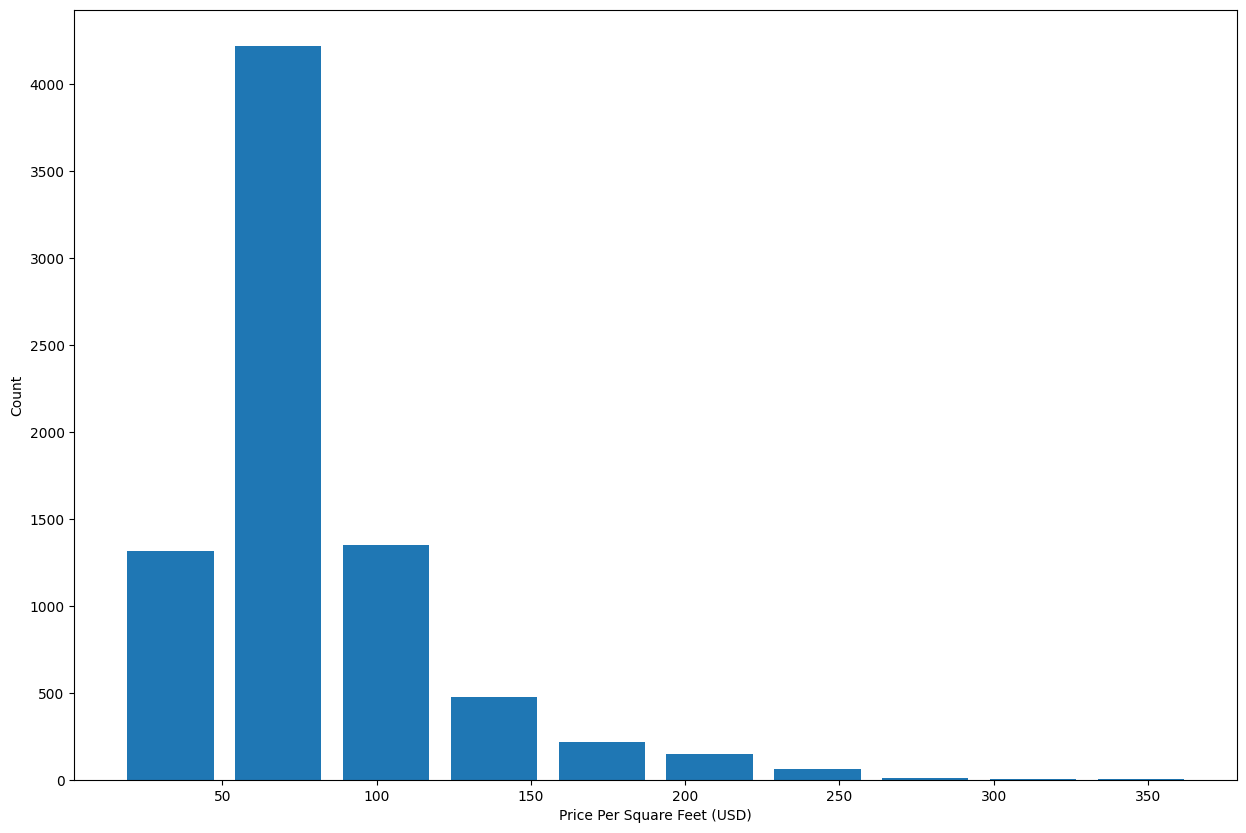

In [47]:
plt.hist(df9.price_USD_per_sqft, rwidth=0.8)
plt.xlabel("Price Per Square Feet (USD)")
plt.ylabel("Count")
plt.show()

We can see that it is a right-skewed distribution.

#### 'bath' outliers - domain knowledge

Based on domain knowledge, we know that *number_of_bathrooms > number_of_bedrooms + 2* are outliers.

In [48]:
df9.bath.value_counts()

bath
2.0     4133
3.0     1968
4.0      660
1.0      626
5.0      233
6.0      106
7.0       34
8.0       17
9.0       10
10.0       2
12.0       2
14.0       1
16.0       1
13.0       1
Name: count, dtype: int64

In [49]:
df9[df9.bath > df9.bhk+2]

,location,size,total_sqft,bath,bhk,price_USD,price_USD_per_sqft
1721,Chikkabanavar,4 Bedroom,2460.0,7.0,4,96602,39.269106
5682,Nagasandra,4 Bedroom,7000.0,8.0,4,543386,77.626571
6203,Rajaji Nagar,5 BHK,7500.0,8.0,5,2052791,273.705467
7337,Thanisandra,3 BHK,1806.0,6.0,3,140073,77.559801
8821,other,9 Bedroom,3300.0,14.0,9,603762,182.958182


In [50]:
df10 = df9[df9.bath < df9.bhk+2]
df10.shape

(7688, 7)

### Final cleaning

We remove the 'size' and 'price_USD_per_sqft' columns, which were needed for outliers detection and are no longer needed for the machine learning model.


In [51]:
data = df10.drop(columns=['size', 'price_USD_per_sqft'])
data.head()

,location,total_sqft,bath,bhk,price_USD
0,1st Block Jayanagar,2850.0,4.0,4,516820
1,1st Block Jayanagar,1630.0,3.0,3,234260
2,1st Block Jayanagar,1875.0,2.0,3,283768
3,1st Block Jayanagar,2400.0,4.0,4,543386
4,1st Block Jayanagar,1000.0,3.0,2,72451


## Step#6: Building Machine-Learning Model

### One Hot Encoding

The first step is to apply One Hot Encoding to the 'locations' column to convert string values into True/False values. Understandable for a machine learning model.

In [52]:
dummies = pd.get_dummies(data.location, drop_first=True)
dummies.head()

,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [53]:
data2 = pd.concat([data, dummies], axis='columns')

In [54]:
# dropping 'location' column because it's not needed anymore
data3 = data2.drop(columns='location')
data3.head()

,total_sqft,bath,bhk,price_USD,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,2850.0,4.0,4,516820,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,234260,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,283768,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2400.0,4.0,4,543386,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1000.0,3.0,2,72451,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Separating dependent and independent features

In [55]:
X = data3.drop(columns='price_USD')
y = data3.price_USD

### Spliting the data for training and testing

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [57]:
len(X_train), len(X_test)

(6150, 1538)

### Training and testing Linear Regression model

In [58]:
from sklearn.linear_model import LinearRegression

lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.737263885937312

### Using K-Fold cross validation to measure accuracy

In [59]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

np.mean(cross_val_score(LinearRegression(), X, y, cv=cv))

0.7713775620071354

### Using the GridSearchCV method to find the best algorithm for our model

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'n_jobs': [None, 1, 2, 3],
                'positive': [False, True]
            },
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic'],
            },
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
                'splitter': ['best', 'random'],
            },
        },
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(
            config['model'], config['params'], cv=cv, return_train_score=False
        )
        gs.fit(X, y)
        scores.append(
            {
                'model': algo_name,
                'best_score': gs.best_score_,
                'best_params': gs.best_params_,
            }
        )

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [61]:
# using unscaled data (without preprocessing)
find_best_model_using_gridsearchcv(X, y)

,model,best_score,best_params
0,linear_regression,0.776190,"{'fit_intercept': True, 'n_jobs': None, 'posit..."
1,lasso,0.771607,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.755592,"{'criterion': 'squared_error', 'splitter': 'ra..."


In [62]:
# using scaled data (with preprocessing)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

find_best_model_using_gridsearchcv(X_std, y)

,model,best_score,best_params
0,linear_regression,0.776190,"{'fit_intercept': True, 'n_jobs': None, 'posit..."
1,lasso,0.771631,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.731186,"{'criterion': 'squared_error', 'splitter': 'ra..."


Linear Regression is performing the best. And scaling the data does not affect the results.

## Step#7: Testing the model

In [63]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Phase JP Nagar',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar', '7th Phase JP Nagar', '8th Phase JP Nagar',
       ...
       'Vishveshwarya Layout', 'Vishwapriya Layout', 'Vittasandra',
       'Whitefield', 'Yelachenahalli', 'Yelahanka', 'Yelahanka New Town',
       'Yelenahalli', 'Yeshwanthpur', 'other'],
      dtype='object', length=233)

In [64]:
# function for price prediction using LinearRegression model
def predict_price_lr(location, sqft, bath, bhk):
    # locating proper 'location' column    
    loc_index = np.where(X.columns == location)[0][0]

    x_pred = np.zeros(len(X.columns))
    x_pred[0] = sqft
    x_pred[1] = bath
    x_pred[2] = bhk
    if loc_index >= 0:
        # setting 'True' for the correct 'location' column
        x_pred[loc_index] = True

    # predicting a price
    return lr_clf.predict([x_pred])[0]

In [65]:
# '6th Phase JP Nagar', 1500 total_sqft, 2 bath, 3 BHK
predict_price_lr('6th Phase JP Nagar', 1500, 2, 3)

136016.6443835387

In [66]:
predict_price_lr('6th Phase JP Nagar', 1500, 2, 2)

137635.78675907373

In [67]:
predict_price_lr('7th Phase JP Nagar', 1800, 2, 3)

163088.4720569587

In [68]:
predict_price_lr('Whitefield', 2300, 4, 4)

218032.20576075732

## Step#8: Exporting

### Export the model to a pickle file to use it on the website for prediction

In [69]:
import pickle

model_file = "banglore_home_prices_model.pickle"
with open(model_file,'wb') as f:
    pickle.dump(lr_clf,f)

### Storing column names for later use on the website

In [70]:
import json

columns = {
    'data_columns' : [col.lower() for col in X.columns]
    }
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))